Note, still in the process of experimenting with parameters

Import packages

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

In [69]:
data = pds.read_pickle('added_t.pkl')

In [7]:
data.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,label,t
0,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,72,71.0
1,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,72,70.0
2,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,72,69.0
3,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,72,68.0
4,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,72,67.0


Import data

In [9]:
#df = pds.read_csv('../../bus203_all_labelled.csv')

# Ignore all other stuff than the ObservedPositionEvent
#df = df[df['event'] == "ObservedPositionEvent"]

In [10]:
#df.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,time_since_journey_start,label
1,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,0,72
3,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,0,72
4,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,0,72
5,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,0,72
6,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,0,72


One hot encode segments, normalize columns and create final dataset

In [136]:
df = data

In [137]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.dt.hour*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.dt.hour*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
#dataset['time_since_journey_start'] = (df['time_since_journey_start']-df['time_since_journey_start'].min())/(df['time_since_journey_start'].max()-df['time_since_journey_start'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

Select an arbitrary number of test journeys

In [138]:
num_test_segments = 700 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, 80% training data

In [139]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['t'][~mask]
test_labels = df['t'][mask]

In [140]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [141]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.sigmoid, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns)),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_27 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 57        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 4         
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________
None


Fit model

In [142]:
EPOCHS=5
# Initial_epoch can be set to resume training after preciously run epochs
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 2468315 samples, validate on 274258 samples
Epoch 1/5
2468315/2468315 [==============================] - 123s 50us/step - loss: 13.6933 - mean_absolute_error: 13.6933 - val_loss: 12.5351 - val_mean_absolute_error: 12.5351
Epoch 2/5
2468315/2468315 [==============================] - 124s 50us/step - loss: 12.2390 - mean_absolute_error: 12.2390 - val_loss: 12.1001 - val_mean_absolute_error: 12.1001
Epoch 3/5
2468315/2468315 [==============================] - 130s 53us/step - loss: 11.9896 - mean_absolute_error: 11.9896 - val_loss: 11.9651 - val_mean_absolute_error: 11.9651
Epoch 4/5
2468315/2468315 [==============================] - 128s 52us/step - loss: 11.8373 - mean_absolute_error: 11.8373 - val_loss: 11.8336 - val_mean_absolute_error: 11.8336
Epoch 5/5
2468315/2468315 [==============================] - 130s 52us/step - loss: 11.7152 - mean_absolute_error: 11.7152 - val_loss: 11.8357 - val_mean_absolute_error: 11.8357


## Evaluate model on all segments 

Evaluate model

In [143]:
model.evaluate(test_data.values, test_labels.values)

569427/569427 [==============================] - 9s 16us/step


[12.04855257265613, 12.04855257265613]

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [144]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

993/993 [==============================] - 0s 502us/step


In [145]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


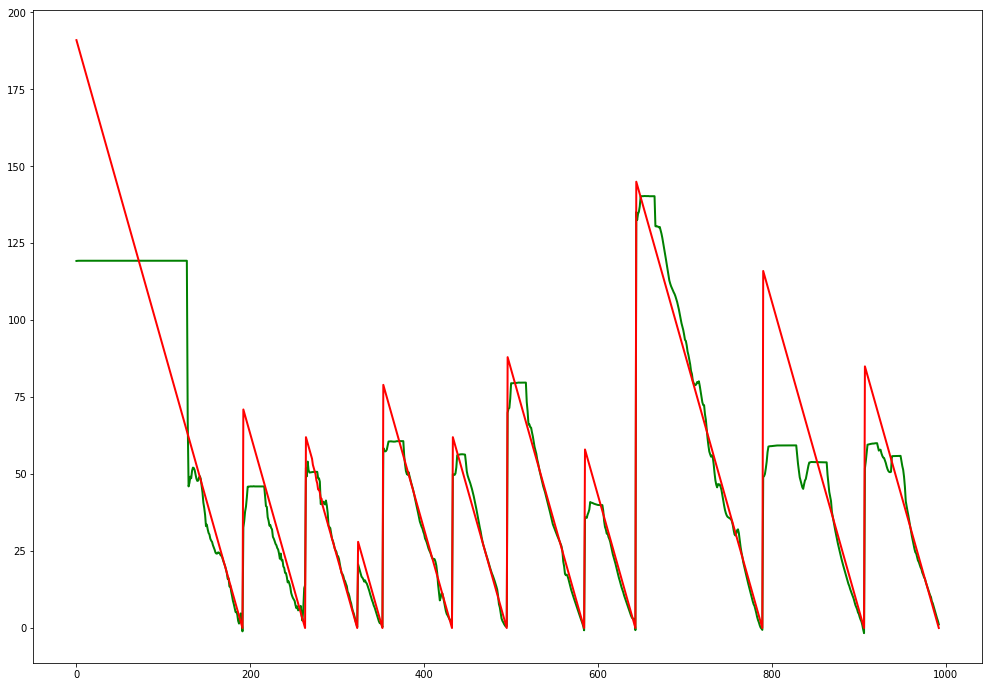

In [146]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()

Note that the plot above contains all 11 segments. The prediction is behaving a little bit different now as it seem to give different predictions for different places within each segment.

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [151]:
# Drop first segment, all journeys
test_ign = test_data[test_data[1] == 0].index
test_ign_d = test_data.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

# Drop first segment, single journey

# Selected journey needs to be in the msk array
selected_journey = np.random.choice(msk)
test_single_j = test_input[test_input['journey_number'] == selected_journey]
to_test = test_single_j.drop(columns=['journey_number'])

test_single = to_test[to_test[1] == 0].index
test_single_d = to_test.loc[test_single]
journey_ = test_labels[test_input['journey_number'] == selected_journey]
test_single_l = journey_.loc[test_single]
test_single_l = test_single_l.reset_index().drop(columns=['index'])

Evaluate model on all data

In [152]:
model.evaluate(test_ign_d.values, test_ign_l.values)

450613/450613 [==============================] - 7s 17us/step


[7.260170842393862, 7.260170842393862]

About 7 seconds m.a.e. Really good to drop the first segment!

In [153]:
predictions = model.predict(test_single_d.values, batch_size=1, verbose=1)

650/650 [==============================] - 0s 409us/step


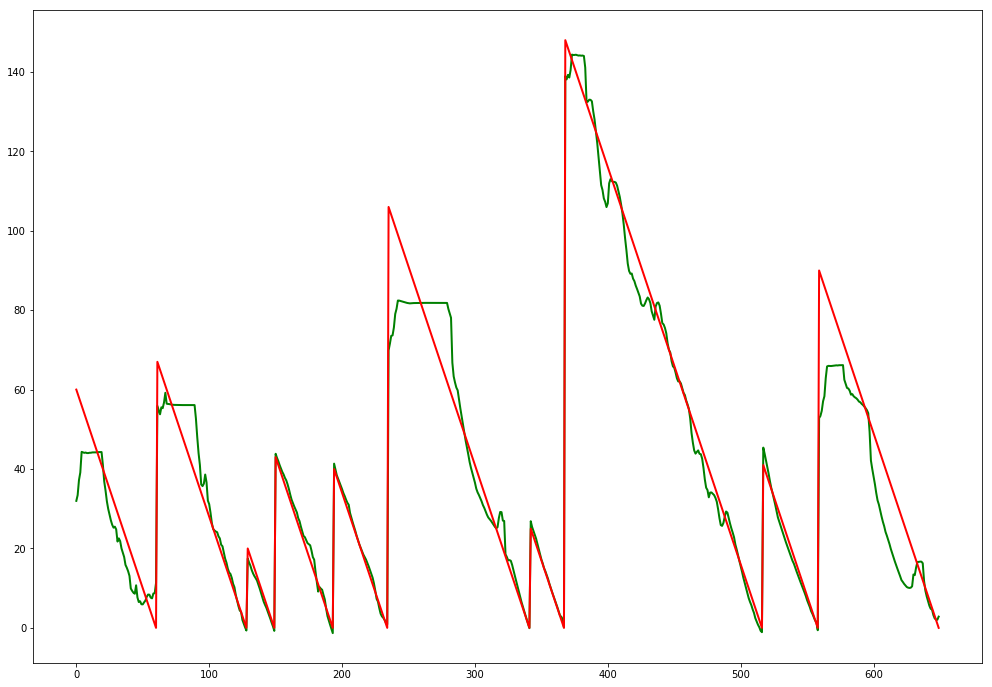

650/650 [==============================] - 0s 27us/step
[4.936257355763362, 4.936257355763362]


In [154]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(test_single_d.values, test_single_l.values))

Below is a final scatterplot from the entire test data set.

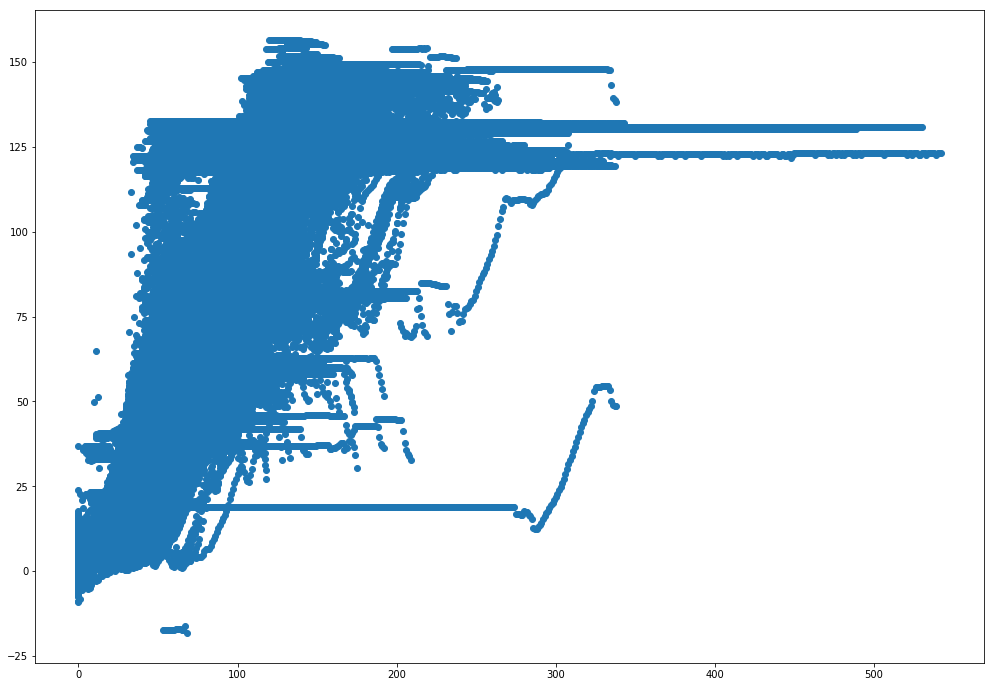

In [155]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()